Data Preprocessing

In [4]:
import os
import requests
import zipfile

# URL of the dataset
url = "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
zip_file = "/content/heart_disease.zip"
extract_dir = "/content/heart_disease"

# Download the zip file
response = requests.get(url)
with open(zip_file, 'wb') as f:
    f.write(response.content)

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files
os.listdir(extract_dir)

['reprocessed.hungarian.data',
 'processed.cleveland.data',
 'hungarian.data',
 'ask-detrano',
 'cleveland.data',
 'bak',
 'processed.hungarian.data',
 'costs',
 'cleve.mod',
 'new.data',
 'WARNING',
 'switzerland.data',
 'long-beach-va.data',
 'processed.switzerland.data',
 'Index',
 'heart-disease.names',
 'processed.va.data']

In [38]:
import pandas as pd

# File path
file_path = "heart_disease/processed.cleveland.data"

# Load the data into a pandas DataFrame
df = pd.read_csv(file_path, header=None)

# Replace all '?' values with 0
df.replace('?', 0, inplace=True)

# Number of features
num_features = 13

# Create column names: x1, x2, ..., x13
column_names = [f"x{i}" for i in range(1, num_features + 1)]

# Add the target column name 'y'
column_names.append("y")

# Rename the columns in the DataFrame
df.columns = column_names

# Drop y column
df.drop('y', axis = 1, inplace = True)

df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


Training Split

In [39]:
from sklearn.model_selection import train_test_split

# Ratio of Split
test_size = 0.2 # 20%

# Random state to achieve similar results
random_state = 42

# Split the data into training and testing sets
df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

In [52]:
import torch
import torch.nn as nn

# 13 -> 7 -> 3 -> 7 -> 13
class Autoencoder(nn.Module):
    def __init__(self, in_dim, layer_1, layer_2):
        super(Autoencoder, self).__init__()
        self.in_dim = in_dim
        self.layer_1 = layer_1
        self.layer_2 = layer_2

        # Encoder
        self.encoder_a = nn.Linear(self.in_dim, self.layer_1)
        self.encoder_b = nn.Linear(self.layer_1, self.layer_2)

        # Decoder
        self.decoder_a = nn.Linear(self.layer_2, self.layer_1)
        self.decoder_b = nn.Linear(self.layer_1, self.in_dim)

        # Activation functions
        self.ReLU = nn.ReLU()

    def encode(self, x):
        x = self.encoder_a(x)
        x = self.ReLU(x)

        x = self.encoder_b(x)
        x = self.ReLU(x)

        return x

    def decode(self, x):
        x = self.decoder_a(x)
        x = self.ReLU(x)

        x = self.decoder_b(x)
        x = self.ReLU(x)

        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)

        return x

model = Autoencoder(13,7,3)

# x = torch.randn(1, 5)

# model.forward(x)

# z = model.encode(x)

# print(z)

Dataset

In [64]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, df_train):
        # Convert NumPy array to a PyTorch tensor
        self.data_x = torch.tensor(df_train, dtype=torch.float32)

    def __len__(self):
        # Return the number of samples (n)
        return self.data_x.shape[0]

    def __getitem__(self, idx):
        # Get the m-dimensional data point at index `idx`
        return self.data_x[idx]

# Get the numpy values from df x and y
# df_train = df_train.values.astype(np.float32)

# Create the training dataset
training_dataset = CustomDataset(df_train)

# Example usage with DataLoader
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

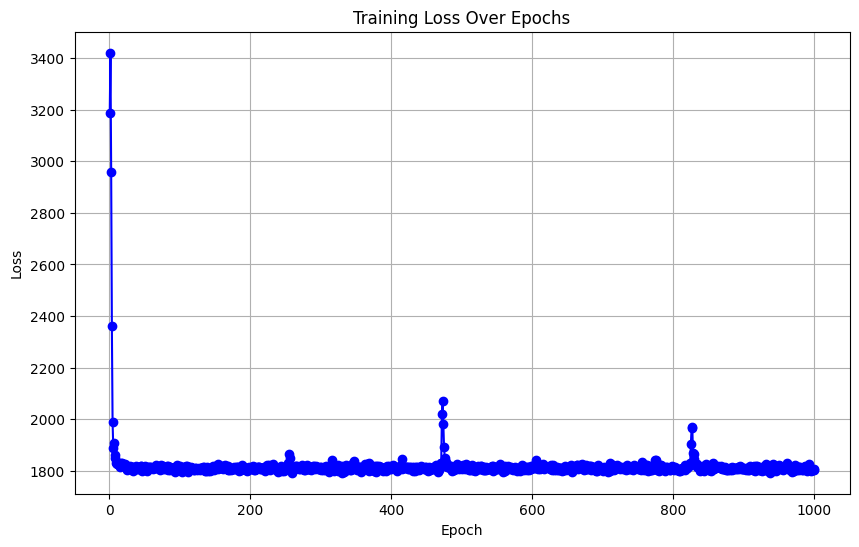

In [65]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Number of epochs
num_epochs = 1000

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1)

# List to store the loss values
loss_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for x_batch in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_batch)

        loss = criterion(y_pred, x_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    avg_loss = running_loss / len(train_loader)
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Append the average loss to the loss_values list
    loss_values.append(avg_loss)

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()